# ЦОИ, Лабораторная работа №1
## Крыжановский Кирилл, 8303
### Лабораторная работа по теме: Геометрические преобразования изображений 

In [1]:
import math

import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

In [2]:
def show_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    figure(figsize=(8, 8), dpi=80)
    plt.imshow(image)
    plt.show()    


def rotate_image(image, angle):
    image_size = (image.shape[1], image.shape[0])
    image_center = tuple(np.array(image_size) / 2)

    rot_mat = np.vstack(
        [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
    )

    rot_mat_notranslate = np.matrix(rot_mat[0:2, 0:2])

    image_w2 = image_size[0] / 2
    image_h2 = image_size[1] / 2

    rotated_coords = [
        (np.array([-image_w2, image_h2]) * rot_mat_notranslate).A[0],
        (np.array([image_w2, image_h2]) * rot_mat_notranslate).A[0],
        (np.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
        (np.array([image_w2, -image_h2]) * rot_mat_notranslate).A[0]
    ]

    # Find the size of the new image
    x_coords = [pt[0] for pt in rotated_coords]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in rotated_coords]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))

    trans_mat = np.matrix([
        [1, 0, int(new_w / 2 - image_w2)],
        [0, 1, int(new_h / 2 - image_h2)],
        [0, 0, 1]
    ])

    affine_mat = (np.matrix(trans_mat) * np.matrix(rot_mat))[0:2, :]

    result = cv2.warpAffine(
        image,
        affine_mat,
        (new_w, new_h),
        flags=cv2.INTER_LINEAR
    )

    return result


def largest_rotated_rect(w, h, angle):
    quadrant = int(math.floor(angle / (math.pi / 2))) & 3
    sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
    alpha = (sign_alpha % math.pi + math.pi) % math.pi

    bb_w = w * math.cos(alpha) + h * math.sin(alpha)
    bb_h = w * math.sin(alpha) + h * math.cos(alpha)

    gamma = math.atan2(bb_w, bb_w) if w < h else math.atan2(bb_w, bb_w)

    delta = math.pi - alpha - gamma

    length = h if w < h else w

    d = length * math.cos(alpha)
    a = d * math.sin(alpha) / math.sin(delta)

    y = a * math.cos(gamma)
    x = y * math.tan(gamma)

    return (
        bb_w - 2 * x,
        bb_h - 2 * y
    )


def crop_around_center(image, width, height):
    image_size = (image.shape[1], image.shape[0])
    image_center = (int(image_size[0] / 2), int(image_size[1] / 2))

    width = min(width, image_size[0])
    height = min(height, image_size[1])

    x1 = int(image_center[0] - width / 2)
    x2 = int(image_center[0] + width / 2)
    y1 = int(image_center[1] - height / 2)
    y2 = int(image_center[1] + height / 2)

    return image[y1:y2, x1:x2]

1. цветное изображение в формате bmp, jpg `path`
2. угол поворота $\alpha \in [0..360)$ - целое число `angle`
3. коэффициент $k \in (0..1]$- рациональное число `k`
4. признак используемой интерполяционной схемы `n`
- 0 - нулевого порядка
- 1 - первого порядка
- 2 - третьего порядка

In [3]:
# DATA
path = r"C:\Users\therealyou\university\digital-imaging\lab1\src\images\horizontal.png"
angle = 305
k = 0.5
n = 0

In [4]:
d = {
    0: cv2.INTER_NEAREST,
    1: cv2.INTER_LINEAR,
    2: cv2.INTER_AREA,
}

## Изначальное изображение

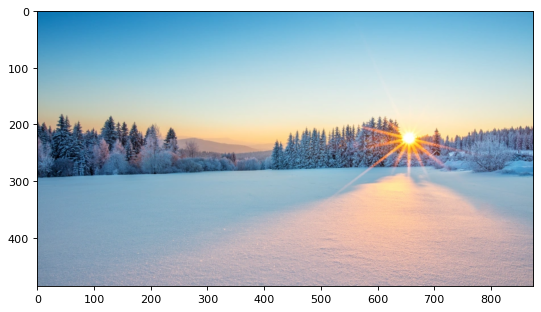

In [5]:
image = cv2.imread(path)
show_image(image)

## Повернутое изображение на angle градусов

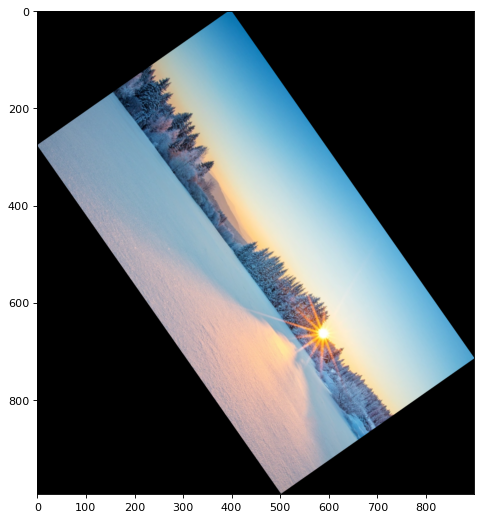

In [6]:
(h, w) = image.shape[:2]
image_rotated = rotate_image(image, angle)
show_image(image_rotated)

## Из повернутого изображения вырезается прямоугольник максимальной площади

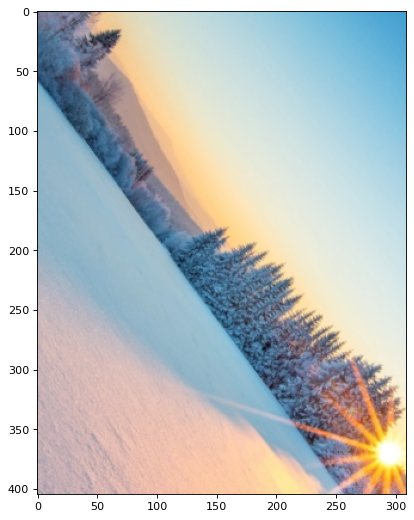

In [7]:
image_rotated_cropped = crop_around_center(
    image_rotated,
    *largest_rotated_rect(w, h, math.radians(angle))
)
show_image(image_rotated_cropped)

## Из повернутого изображения вырезается прямоугольник максимальной площади

> Данное изображение **увеличивается** по оси Y в `1/k` раз и **уменьшается** по оси Х в `k` раз.

Иными словами каждая сторона уменьшается в `k` раз. Условие такое :(

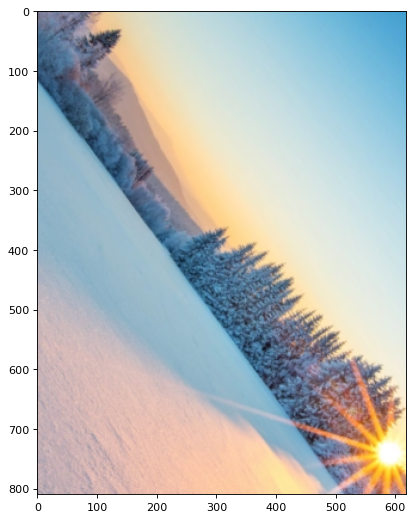

In [10]:
(h, w) = image_rotated_cropped.shape[:2]
down_points = (int(w * (1 / k)), int(h / k))
resized_image_rotated_cropped = cv2.resize(image_rotated_cropped, down_points, interpolation=d[n])
show_image(resized_image_rotated_cropped)

## Из повернутого изображения вырезается прямоугольник максимальной площади

Данное изображение **увеличивается** по оси Y в `k` раз и **уменьшается** по оси Х в `k` раз.

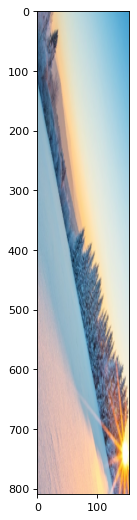

In [11]:
(h, w) = image_rotated_cropped.shape[:2]
down_points = (int(w * k), int(h / k))
resized_image_rotated_cropped = cv2.resize(image_rotated_cropped, down_points, interpolation=d[n])
show_image(resized_image_rotated_cropped)